# 네이버 영화리뷰 감정 분석에 SentencePiece 적용하기 (v2)

## 목표
1. 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
2. 학습된 모델로 `sp_tokenize()` 메소드 구현하기
3. 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
4. KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
5. SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from soynlp.normalizer import emoticon_normalize
import sentencepiece as spm
import os

import warnings
warnings.filterwarnings('ignore')

## 1. 데이터 로드 및 전처리

In [2]:
# 데이터 다운로드 (이미 다운로드했다면 주석 처리)
# !wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
# !wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

train_df = pd.read_table('ratings_train.txt')
test_df = pd.read_table('ratings_test.txt')

In [3]:
def preprocess_data(df, is_train=True):
    df_name = '훈련' if is_train else '테스트'
    print(f'--- {df_name} 데이터 전처리 ---')
    print(f'전처리 전 데이터 개수: {len(df)}')
    df.dropna(inplace=True)
    print(f'결측치 제거 후: {len(df)}개')
    if is_train:
        df.drop_duplicates(subset=['document'], inplace=True)
        print(f'중복 제거 후: {len(df)}개')
    df['document'] = df['document'].apply(lambda x: emoticon_normalize(x, num_repeats=2))
    df = df[~df['document'].str.match('^[ㄱ-ㅎㅏ-ㅣ]+$', na=False)]
    min_char_len = 3
    max_char_len = 140
    df = df[df['document'].str.len() >= min_char_len]
    df['document'] = df['document'].str.slice(0, max_char_len)
    print(f'최종 데이터 개수: {len(df)}개')
    return df

train_df_clean = preprocess_data(train_df.copy(), is_train=True)
test_df_clean = preprocess_data(test_df.copy(), is_train=False)

--- 훈련 데이터 전처리 ---
전처리 전 데이터 개수: 150000
결측치 제거 후: 149995개
중복 제거 후: 146182개
최종 데이터 개수: 145594개
--- 테스트 데이터 전처리 ---
전처리 전 데이터 개수: 50000
결측치 제거 후: 49997개
최종 데이터 개수: 49369개


## 2. SentencePiece 모델 학습 및 토크나이저 구현

In [4]:
# 1. 말뭉치(Corpus) 파일 생성
corpus_file = 'nsmc_corpus.txt'
with open(corpus_file, 'w', encoding='utf-8') as f:
    for row in train_df_clean['document']:
        f.write(f'{row}\n')

# 2. SentencePiece 모델 학습
model_prefix = 'nsmc_spm'
vocab_size = 8000
model_type = 'unigram'
params = f'--input={corpus_file} --model_prefix={model_prefix} --vocab_size={vocab_size} --model_type={model_type}'
spm.SentencePieceTrainer.Train(params)
print('SentencePiece 모델 학습 완료!')

# 3. 학습된 모델 로드
sp = spm.SentencePieceProcessor()
sp.Load(f'{model_prefix}.model')

SentencePiece 모델 학습 완료!


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=nsmc_corpus.txt --model_prefix=nsmc_spm --vocab_size=8000 --model_type=unigram
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: nsmc_corpus.txt
  input_format: 
  model_prefix: nsmc_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 

True

In [5]:
# 4. 토크나이저 함수 구현
def sp_tokenize(s, corpus):
    sequences = [s.EncodeAsIds(text) for text in corpus]
    sequences = [torch.tensor(seq, dtype=torch.long) for seq in sequences]
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0) # pad_id=0
    return padded_sequences

# 5. 데이터 토큰화 및 텐서 변환
X_train = sp_tokenize(sp, train_df_clean['document'].tolist())
X_test = sp_tokenize(sp, test_df_clean['document'].tolist())
y_train = torch.tensor(train_df_clean['label'].values, dtype=torch.float32)
y_test = torch.tensor(test_df_clean['label'].values, dtype=torch.float32)

print('SentencePiece 토큰화 완료!')
print('Train data shape:', X_train.shape)
print('Test data shape:', X_test.shape)

SentencePiece 토큰화 완료!
Train data shape: torch.Size([145594, 134])
Test data shape: torch.Size([49369, 118])


## 3. 모델 학습 및 평가

In [6]:
# 훈련/검증 데이터 분리 및 DataLoader 생성
val_size = 40000
X_val, y_val = X_train[:val_size], y_train[:val_size]
X_train_final, y_train_final = X_train[val_size:], y_train[val_size:]

train_dataset = TensorDataset(X_train_final, y_train_final)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 512
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [7]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, padding_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        out = self.fc(hidden)
        return self.sigmoid(out)

class CNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = embedding_dim, out_channels = n_filters, kernel_size = fs)
                                    for fs in filter_sizes
                                    ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x).permute(0, 2, 1)
        conved = [torch.relu(conv(embedded)) for conv in self.convs]
        pooled = [torch.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim = 1))
        out = self.fc(cat)
        return self.sigmoid(out)

In [8]:
def train_and_evaluate_with_plot(model, train_loader, val_loader, test_loader, num_epochs, device, lr=1e-3):
    model = model.to(device)
    criterion = nn.BCELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    print(f'--- {type(model).__name__} 모델 학습 시작 ---')
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss, epoch_train_correct, epoch_train_total = 0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            epoch_train_correct += (predicted == labels).sum().item()
            epoch_train_total += labels.size(0)
        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_train_acc = epoch_train_correct / epoch_train_total
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(avg_train_acc)
        model.eval()
        epoch_val_loss, epoch_val_correct, epoch_val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                epoch_val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                epoch_val_correct += (predicted == labels).sum().item()
                epoch_val_total += labels.size(0)
        avg_val_loss = epoch_val_loss / len(val_loader)
        avg_val_acc = epoch_val_correct / epoch_val_total
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(avg_val_acc)
        print(f'Epoch [{epoch+1}/{num_epochs}] -> Train Loss: {avg_train_loss:.4f}, Acc:{avg_train_acc:.4f} | Val Loss: {avg_val_loss:.4f}, Acc: {avg_val_acc:.4f}')
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            predicted = (outputs > 0.5).float()
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    test_accuracy = test_correct / test_total
    print(f'Final Test Accuracy: {test_accuracy:.4f}')
    return history, test_accuracy

def plot_history(history, model_name):
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy', color='darkblue', marker='o')
    plt.plot(history['val_acc'], label='Validation Accuracy', color='crimson', marker='o')
    plt.title(f'{model_name} - Accuracy', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss', color='darkblue', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', color='crimson', marker='o')
    plt.title(f'{model_name} - Loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [9]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

VOCAB_SIZE = sp.GetPieceSize()
EMBEDDING_DIM = 128
HIDDEN_DIM = 128
OUTPUT_DIM = 1
NUM_EPOCHS = 6
LEARNING_RATE = 1e-3

bilstm_model = LSTMModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, padding_idx=0)
bilstm_history, bilstm_test_acc = train_and_evaluate_with_plot(bilstm_model, train_loader,val_loader, test_loader, NUM_EPOCHS, device, lr=LEARNING_RATE)

N_FILTERS = 100
FILTER_SIZES = [3,4,5]
DROPOUT = 0.5

cnn_model = CNNModel(VOCAB_SIZE, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)
cnn_history, cnn_test_acc = train_and_evaluate_with_plot(cnn_model, train_loader, val_loader, test_loader, NUM_EPOCHS, device, lr=LEARNING_RATE)

Using device: mps
--- LSTMModel 모델 학습 시작 ---
Epoch [1/6] -> Train Loss: 0.5994, Acc:0.6725 | Val Loss: 0.5023, Acc: 0.7567
Epoch [2/6] -> Train Loss: 0.4215, Acc:0.8112 | Val Loss: 0.3945, Acc: 0.8240
Epoch [3/6] -> Train Loss: 0.3468, Acc:0.8516 | Val Loss: 0.3625, Acc: 0.8412
Epoch [4/6] -> Train Loss: 0.3070, Acc:0.8712 | Val Loss: 0.3598, Acc: 0.8447
Epoch [5/6] -> Train Loss: 0.2781, Acc:0.8850 | Val Loss: 0.3645, Acc: 0.8478
Epoch [6/6] -> Train Loss: 0.2514, Acc:0.8975 | Val Loss: 0.3590, Acc: 0.8508
Final Test Accuracy: 0.8484
--- CNNModel 모델 학습 시작 ---
Epoch [1/6] -> Train Loss: 0.6119, Acc:0.6543 | Val Loss: 0.5002, Acc: 0.7587
Epoch [2/6] -> Train Loss: 0.4644, Acc:0.7798 | Val Loss: 0.4183, Acc: 0.8113
Epoch [3/6] -> Train Loss: 0.3886, Acc:0.8244 | Val Loss: 0.3792, Acc: 0.8334
Epoch [4/6] -> Train Loss: 0.3438, Acc:0.8499 | Val Loss: 0.3620, Acc: 0.8425
Epoch [5/6] -> Train Loss: 0.3185, Acc:0.8633 | Val Loss: 0.3520, Acc: 0.8479
Epoch [6/6] -> Train Loss: 0.2969, Acc:0.87

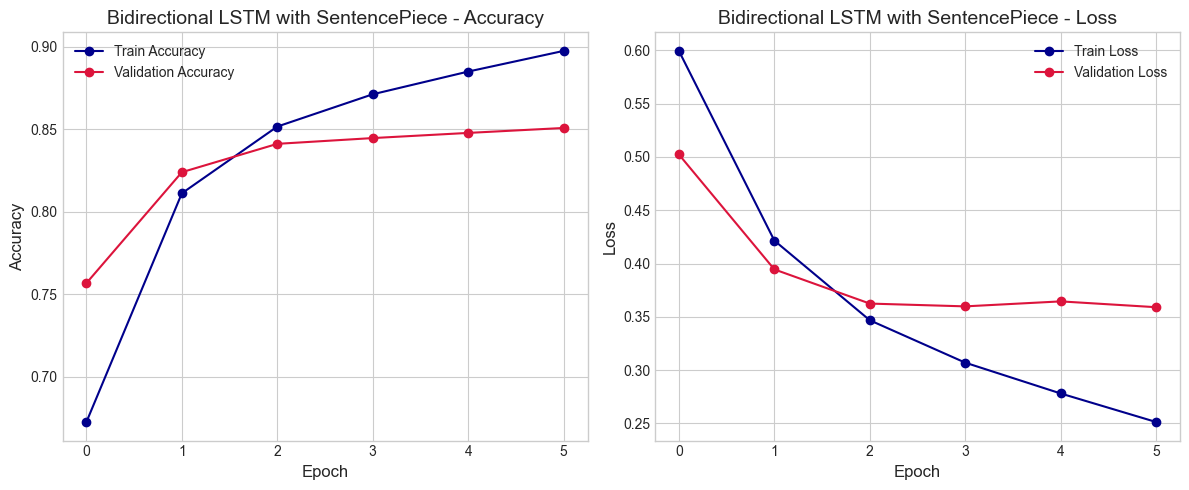

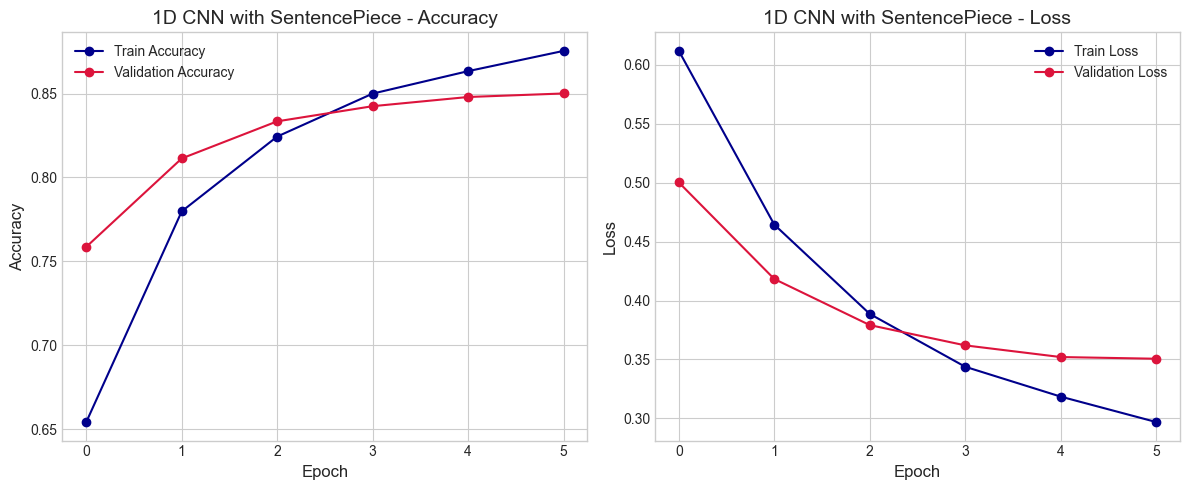

In [10]:
plot_history(bilstm_history, 'Bidirectional LSTM with SentencePiece')
plot_history(cnn_history, '1D CNN with SentencePiece')